# Predicting Baseball Strike Zones Using Support Vector Machines (SVM)

## What is SVM?
It is a supervised machine learning model that is used for classification. 

Its classification actions are peformed by defining a **`decision boundary`** and then figuring out what side of the boundary the data points fall on.

In selecting the decision boundary, since there is an infinite number of solutions, **the general rule of thumb is to have the choose a decision boundary that is as far away from the training data points as possible.** 

The **`support vectors`**--which are the training datapoints that are the closest to the decision boundary--are what defines the decision boundary. And this is also why SVMs are fast acting classifiers since they do not have to use every training datapoint for classification. 

The distance between the support vectors and the decision boundary is called the **`margin`**.

The shape of the decision boundary depends on the data set of interest and SVM handles this by using **`Kernels`**

## Project Description

Here, I will be **using SVM to predict (decide) whether or not a pitch from a baseball player is a strike or a ball.**

For the novices here are some basic keypoints about the baseball game and the figure below provides a better illustration: 

![base](images/baseball2.png)

**a. Strike Zone**: From the image, the strike zone is the area between the Batter's knee and midpoint, and it also span across the width of the home plate (the white polygon located below the strike zone and shown in the figure above)

**b. Pitcher**: The player that throws the base ball in an attempt to make it difficult for the batter to hit the ball.

**c. Batter(Striker)**: The player from the opposing team who stands at home plate and attempts to hit the pitches from the pitcher.

**d. Pitch**: This is a single throw ( could be a fastball, curveball, slider etc) of the baseball by the pitcher towards the batter. A pitch is considered a `strike` or a `ball` based on its location within the strike zone and the batter's decision to swing.

**e. Strike**: 

* A pitch is a strike if it crosses any part of the strike zone AND the batter does not swing at it. 

* A strike is counted against the batter when they swing at and miss a pitch OR when a pitch that is in the strike zone is not swung at.

**f. Ball**: 

* A pitch is a ball if it doesn't cross the strike zone OR if the batter doesn't swing and the pitch is outside the strike zone. 

* A ball is counted against the batter when a pitch is thrown outside the strike zone and the batter doesn't swing.

Baseball is a complex game with many rules and strategies, but these keypoints should be more than enough for our SVM project!!!

The datasets for this project are gotten through the [pybaseball](https://github.com/jldbc/pybaseball) Python package. **Please note that in order to use the pybaseball module, you need access to the internet**



## Data Import, Inspection, and Cleaning

In [1]:
#Step1: Let's import the data of some baseball players and other relevant libraries

from pybaseball import playerid_lookup, statcast_batter
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import warnings
%matplotlib widget
# %matplotlib inline

# Ignore all warnings
warnings.filterwarnings("ignore")

#Let's define a function to fetch data for a player and return a DataFrame
def get_player_data(player_name):
    # Get player IDs
    player_ids = playerid_lookup(player_name.split()[1], player_name.split()[0]);
    player_id = player_ids.iloc[0]['key_mlbam'];
    
    # Get Statcast data for the player for the 2017 season
    player_statcast_data = statcast_batter('2022-01-01', '2022-12-31', player_id);
#     player_statcast_data = statcast_batter('2023-01-01', '2023-08-13', player_id);
    
    return player_statcast_data

aaron_judge = get_player_data('Aaron Judge')
jose_altuve = get_player_data('Jose Altuve')

#Let's look at all of the features of a pitch
print(aaron_judge.columns.tolist())


Gathering player lookup table. This may take a moment.
Gathering Player Data
Gathering Player Data
['pitch_type', 'game_date', 'release_speed', 'release_pos_x', 'release_pos_z', 'player_name', 'batter', 'pitcher', 'events', 'description', 'spin_dir', 'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des', 'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type', 'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b', 'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed', 'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1', 'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y', 'estimated_b

In [2]:
#Step2: Let's learn what some of the features mean, for example 'description'

print(aaron_judge.description.unique())

['hit_into_play' 'ball' 'called_strike' 'blocked_ball' 'foul'
 'swinging_strike' 'swinging_strike_blocked' 'foul_tip' 'hit_by_pitch']


The result above shows all the possible descriptions of the resulting pitch. That is, it can be a swinging strike, hit into play, foul, etc

In [3]:
#Step3: Let's view the information that shows whether a pitch within our dataset is a strike or a ball
#This info is stored in the column `type` of the dataset

print(aaron_judge.type.unique())

['X' 'B' 'S']


The type above are short hand forms of the pitch result, where 

* **S = strike**
* **X = in play (or neither). It could be a hit or an out**
* **B = ball**

Therefore, we will be using this feature as the label of our data point. 

**And for brevity, we will map their string values into integers, where every *`S`* becomes *`1`* and every *`B`* becomes *`0`* while we discard `X`**

In [4]:
#Step4: Let's use the map() function to make the changes above--from string to integer--for the type column
def type_map(df):
    df['type'] = df['type'].map({'S':1,'B':0})
    return df
aaron_judge = type_map(aaron_judge)
print(aaron_judge.type.unique())

[nan  0.  1.]


It can be seen that there are some `nan`'s in the `type` column of the dataset, this is because of the ummapped `X` values from Step3.

The next is to predict the pitch-type by using the baseball's location over the plate, this information is stored in the columns `plate_x` and `plate_z`. 

Where:

* **plate_x is the horizontal position of the ball when it crosses home plate from the catcher's perspective.**

* **plate_z the vertical position of the ball when it crosses home plate from the catcher's perspective.**

In a layman's term, the x-axis and z-axis in baseball refer to specific spatial dimensions within the strike zone. 

The x-axis runs horizontally across the width of home plate and **an x-axis value of 0 refers to the center of the plate**;

While the z-axis runs vertically from just above the ground to the batter's shoulders. **A z-axis value of 0 means that the pitch was at ground level** 

In [5]:
#Step5: Let's see what the plate_x and plate_z column looks like
print(aaron_judge.plate_x)
print()
print(aaron_judge.plate_z)

0      -0.15
1      -0.40
2       0.58
3      -0.28
4      -1.32
        ... 
3198   -0.08
3199    0.37
3200   -0.01
3201    0.99
3202   -0.09
Name: plate_x, Length: 3203, dtype: float64

0       2.45
1       1.80
2       2.23
3       1.56
4       5.01
        ... 
3198    1.87
3199    2.02
3200    4.63
3201    2.29
3202    1.73
Name: plate_z, Length: 3203, dtype: float64


In [6]:
#Step6: Let's remove the NaN values from our 3 columns of interest plate_x,plate_z & type
aaron_judge = aaron_judge.dropna(subset = ['plate_x','plate_z','type'])

## Data Visualization

From here, we would make an X-Y scatter plot in a bid to depict the strike zone, where x-axis is the plate_x column and y-axis is the plate_z column

We would then color the points using data from the type column:

#### **The strikes are colored red** and **the balls are colored blue**.

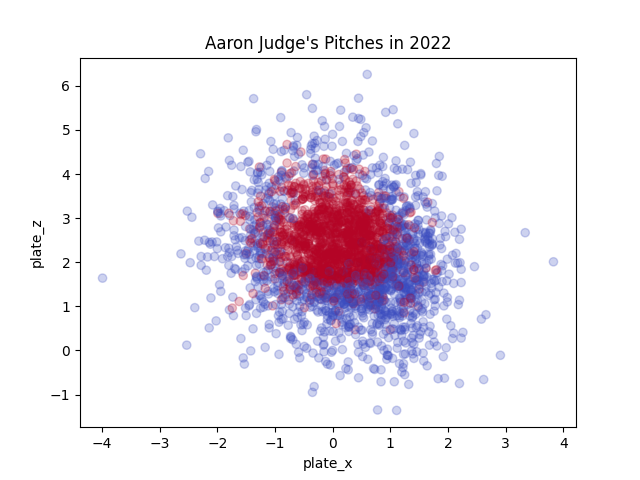

In [7]:
# Step7: Let's make an X-Y plot
plt.figure(1)
plt.scatter(x = aaron_judge['plate_x'], y = aaron_judge['plate_z'], c = aaron_judge['type'], cmap = plt.cm.coolwarm, alpha = 0.25)
plt.title("Aaron Judge's Pitches in 2022")
plt.xlabel('plate_x')
plt.ylabel('plate_z')
plt.show()

The image above shows the location of every pitch and their original classification as either a strike(red points) or a ball(in blue points).

## SVM Modelling
We will now create an **SVM** to create a decision boundary. This boundary will then represent the real strike zone for the player.

In [8]:
#Step8: Let's split the data into a training set and a test dataset
training_set, test_set = train_test_split(aaron_judge, random_state=1)

#Step9: Create a support vector classifier object using a radial basis function kerneæ 
classifier = SVC(kernel='rbf');

#Step10: fit the model to our training dataset where the input is x&z-axis data and the label(output) is the type
classifier.fit(training_set[['plate_x','plate_z']],training_set['type']);

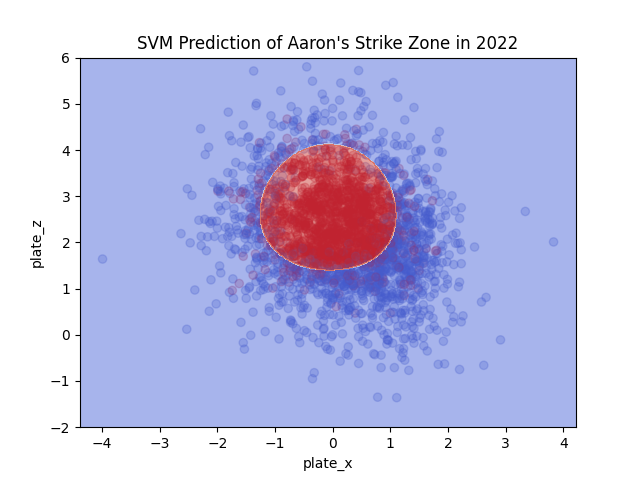

In [9]:
#Step11: Let's visualize the SVM using the draw_boundary function below
def make_meshgrid(ax, h=.02):
    # x_min, x_max = x.min() - 1, x.max() + 1
    # y_min, y_max = y.min() - 1, y.max() + 1
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy
def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out
def draw_boundary(ax, clf):
    xx, yy = make_meshgrid(ax)
    return plot_contours(ax, clf, xx, yy,cmap=plt.cm.coolwarm, alpha=0.5)

fig, ax = plt.subplots()
plt.figure(2)
plt.scatter(x = aaron_judge['plate_x'], y = aaron_judge['plate_z'], c = aaron_judge['type'], cmap = plt.cm.coolwarm, alpha = 0.25)
plt.title("SVM Prediction of Aaron's Strike Zone in 2022")
plt.xlabel('plate_x')
plt.ylabel('plate_z')
ax.set_ylim(-2,6)
draw_boundary(ax,classifier)
plt.show()

It is evident from the Figure 2 above that the SVM has a pretty decent prediction of the strike zone for Aaron Judge, since the red circle it drew covers the bulk of the red dots.

## Assesssing the Model's Accuracy

Just to be sure, about the strike zone predicted by the SVM, let's get an empirical proof of the SVM's classification accuracy by checking its score.

In [10]:
#Step12: Let's check the SVM's scores
score = classifier.score(test_set[['plate_x','plate_z']],test_set['type'])
print(score)

0.8519593613933236


We can see that the score is about 85.2% and one reason for this is evident from the Figure 2 above, since the classifier is still missing some of those red spots.

We can try to improve this by tuning some of SVM's hyperparameters such as the `gamma` and `C` value. 

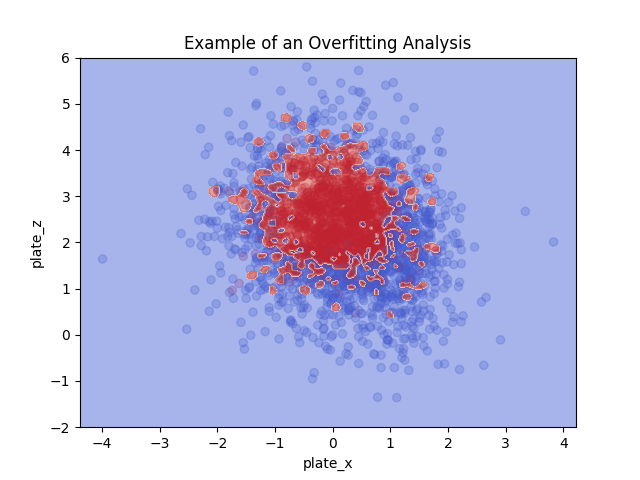

0.7793904208998549


In [11]:
#Step13: First, let's test out some values of gamma and C and compute Steps 9-12 again
    #Step9_2:Create a support vector classifier object using a radial basis function kernel
classifier = SVC(kernel='rbf',gamma = 100, C  = 100)

    #Step10_2: fit the model to our training dataset where the input is x&z-axis data and the label(output) is the type
classifier.fit(training_set[['plate_x','plate_z']],training_set['type'])

# plt.figure()
fig, ax = plt.subplots()
plt.figure(3)
plt.scatter(x = aaron_judge['plate_x'], y = aaron_judge['plate_z'], c = aaron_judge['type'], cmap = plt.cm.coolwarm, alpha = 0.25)
plt.title('Example of an Overfitting Analysis')
plt.xlabel('plate_x')
plt.ylabel('plate_z')
ax.set_ylim(-2,6)
draw_boundary(ax,classifier)
plt.show()

    #Step12_2: Let's check the SVM's scores
score = classifier.score(test_set[['plate_x','plate_z']],test_set['type'])
print(score)


From the Figure 3 above, it can be seen that the present configuration of the hyperparameters **(gamma = C = 100)** has reduced the accuracy of the classification and also produced overfitted results.

## Hyperparameter Tuning

Now, let's try to tune the hyperparameters by performing a search within a range of values. And then selecting the combination that produces the highest accuracy.

{'score': 0.8534107402031931, 'gamma': 2, 'C': 2}


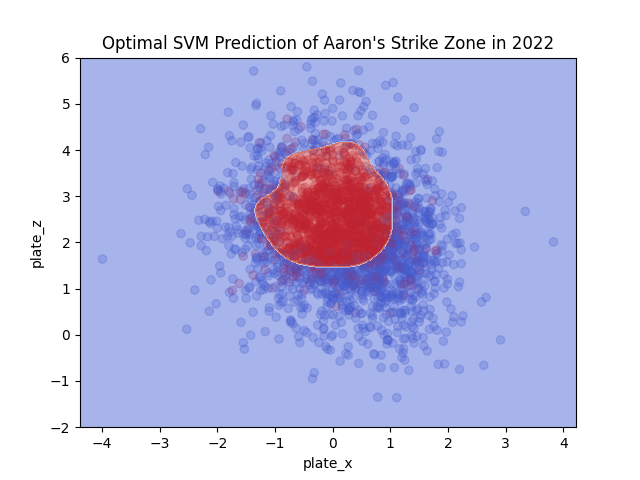

In [12]:
#Step14: Hyper parameter tuning by trying a configuration 

#define a buffer dictionary to store the highest score, its gamma and C
largest = {'score': 0, 'gamma': 0, 'C':0}

for gamma in range(1,10):
    for C in range(1,10):
        classifier = SVC(kernel = 'rbf', gamma = gamma, C = C)
        classifier.fit(training_set[['plate_x','plate_z']],training_set['type'])
        score = classifier.score(test_set[['plate_x','plate_z']],test_set['type'])
        if (score > largest['score']):
            largest['score'] = score
            largest['gamma'] = gamma
            largest['C'] = C
print(largest)

#use the optimal parameters to make a new model and a plot
classifier = SVC(kernel = 'rbf', gamma = largest['gamma'], C = largest['C'])
classifier.fit(training_set[['plate_x','plate_z']],training_set['type'])    

fig, ax = plt.subplots()
plt.figure(4)
plt.scatter(x = aaron_judge['plate_x'], y = aaron_judge['plate_z'], c = aaron_judge['type'], cmap = plt.cm.coolwarm, alpha = 0.25)
plt.title("Optimal SVM Prediction of Aaron's Strike Zone in 2022")
plt.xlabel('plate_x')
plt.ylabel('plate_z')
ax.set_ylim(-2,6)
draw_boundary(ax,classifier)
plt.show()

Now, that we have developed various programs to clean our data, visualize our data, use the processed data to train an SVM and test the SVM model.

## Compression of the modelling procedure into a single function

Let us now try to compress all these programs into a single function that can take the dataset of any player and compute all the steps mentioned earlier.


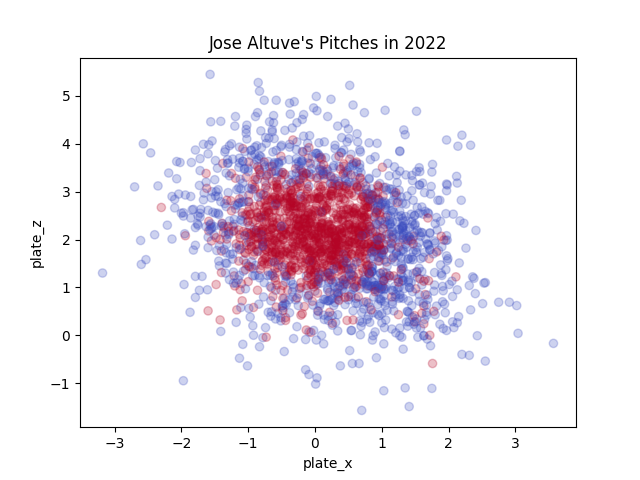

{'score': 0.8171206225680934, 'gamma': 4, 'C': 5}


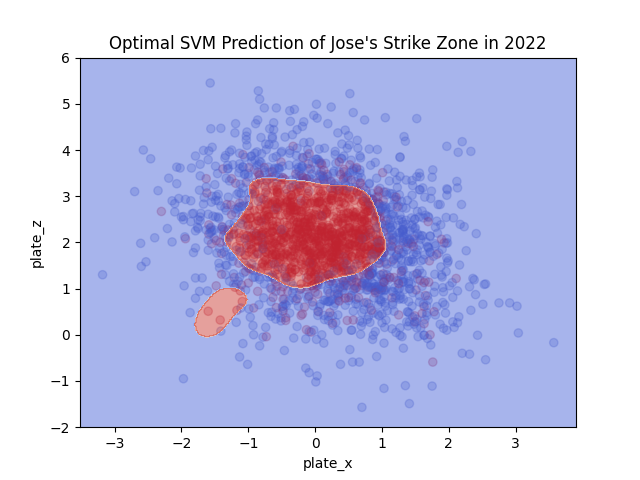

In [13]:
#Step15: Let's define a function to clean and visualize our dataset while training and testing an SVM model
def perform_SVM(df,name):

    #1: Let's use the map() function to map the strings in the type column into integers
    df = type_map(df)

    #2: Let's remove the NaN values from our 3 columns of interest plate_x,plate_z & type
    df = df.dropna(subset = ['plate_x','plate_z','type'])
    
    #3: Let's make an X-Y scatter plot
    plt.figure(5)
    plt.scatter(x = df['plate_x'], y = df['plate_z'], c = df['type'], cmap = plt.cm.coolwarm, alpha = 0.25)
    plt.title(f"{name}'s Pitches in 2022")
    plt.xlabel('plate_x')
    plt.ylabel('plate_z')
    plt.show()

    #4: Let's split the data into a training set and a test dataset
    training_set, test_set = train_test_split(df, random_state=1)
    
    #5: Hyper parameter tuning by searching through a configuration space

    #define a buffer dictionary to store the highest score, its gamma and C
    largest = {'score': 0, 'gamma': 0, 'C':0}

    for gamma in range(1,10):
        for C in range(1,10):
            classifier = SVC(kernel = 'rbf', gamma = gamma, C = C)
            classifier.fit(training_set[['plate_x','plate_z']],training_set['type'])
            score = classifier.score(test_set[['plate_x','plate_z']],test_set['type'])
            if (score > largest['score']):
                largest['score'] = score
                largest['gamma'] = gamma
                largest['C'] = C
    print(largest)
    
    #6: Let's use the optimal parameter from step 5 to train a model
    classifier = SVC(kernel = 'rbf', gamma = largest['gamma'], C = largest['C'])
    classifier.fit(training_set[['plate_x','plate_z']],training_set['type'])    
    
    #5: Let's visualize the result of the optimal SVM
    fig, ax = plt.subplots()
    plt.figure(6)
    plt.scatter(x = df['plate_x'], y = df['plate_z'], c = df['type'], cmap = plt.cm.coolwarm, alpha = 0.25)
    plt.title(f"Optimal SVM Prediction of {name.split(' ')[0]}'s Strike Zone in 2022")
    plt.xlabel('plate_x')
    plt.ylabel('plate_z')
    ax.set_ylim(-2,6)
    draw_boundary(ax,classifier)
    plt.show()


    
#Step16: Test the function on a sample dataset    
perform_SVM(jose_altuve, 'Jose Altuve')